# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import pyspark

In [3]:
import yfinance as yahooFinance

In [4]:
from pandasql import sqldf

# Load Data

In [5]:
AAPL = yahooFinance.Ticker("AAPL")
df =  pd.DataFrame(AAPL.history(period="3y"))

In [6]:
q = """
WITH raw AS (
    SELECT
        date,
        close,
        LAG(close, 1) OVER (ORDER BY date) AS min_1_close,
        LAG(close, 2) OVER (ORDER BY date) AS min_2_close,
        LAG(close, 3) OVER (ORDER BY date) AS min_3_close,
        LAG(close, 4) OVER (ORDER BY date) AS min_4_close
    FROM
        df
),
raw_plus_trend AS (
    SELECT
        date,
        close,
        min_1_close,
        CASE WHEN min_1_close - min_2_close > 0 THEN 1 ELSE -1 END AS min_1_trend,
        CASE WHEN min_2_close - min_3_close > 0 THEN 1 ELSE -1 END AS min_2_trend,
        CASE WHEN min_3_close - min_4_close > 0 THEN 1 ELSE -1 END AS min_3_trend
    FROM
        raw
),
train_data AS (
    SELECT
        date,
        close,
        min_1_close AS day_prev_close,
        CASE WHEN min_1_trend + min_2_trend + min_3_trend > 0 THEN 1 ELSE -1 END AS trend_3_day
    FROM
        raw_plus_trend
    ORDER BY
        date ASC
)
SELECT
    *
FROM
    train_data
"""
df = sqldf(q,globals())

In [7]:
print(type(df))
df.dropna(inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,close,day_prev_close,trend_3_day
1,2020-10-01 00:00:00.000000,114.716454,113.753845,-1
2,2020-10-02 00:00:00.000000,111.013374,114.716454,-1
3,2020-10-05 00:00:00.000000,114.431602,111.013374,-1
4,2020-10-06 00:00:00.000000,111.150909,114.431602,1
5,2020-10-07 00:00:00.000000,113.036812,111.150909,-1


In [8]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

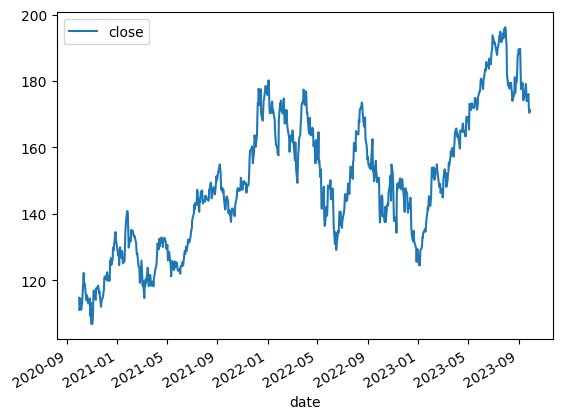

In [9]:
df.plot(x='date', y='close')

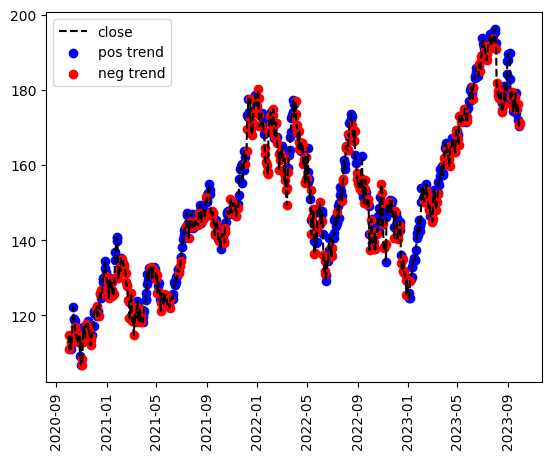

In [10]:
start_date = df['date'].min()
end_date = df['date'].max()

plt.plot(
    'date', 'close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_3_day == 1 & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_3_day == -1) & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [11]:
df.shape

(754, 4)

# Model Development

In [12]:
features = ['day_prev_close', 'trend_3_day']
target = 'close'
x = df[features]
y = df[target]

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = x.loc[:527],x.loc[527:],y.loc[:527],y.loc[527:]

In [108]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def calculate_explained_variance(y_true, y_pred):
    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    return explained_variance

def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    test_r2 = r2_score(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
    overfitting_indication = train_r2 - test_r2
    
    return test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication

# Linear Regression
lr = LinearRegression()
lr_test_r2, lr_train_r2, lr_mae, lr_mse, lr_rmse, lr_explained_variance, lr_adjusted_r2, lr_overfitting = evaluate_model(lr, x_train, y_train, x_test, y_test)

# Lasso
ls = Lasso()
ls_test_r2, ls_train_r2, ls_mae, ls_mse, ls_rmse, ls_explained_variance, ls_adjusted_r2, ls_overfitting = evaluate_model(ls, x_train, y_train, x_test, y_test)

# Ridge
rg = Ridge()
rg_test_r2, rg_train_r2, rg_mae, rg_mse, rg_rmse, rg_explained_variance, rg_adjusted_r2, rg_overfitting = evaluate_model(rg, x_train, y_train, x_test, y_test)

# Decision Tree
dt = DecisionTreeRegressor()
dt_test_r2, dt_train_r2, dt_mae, dt_mse, dt_rmse, dt_explained_variance, dt_adjusted_r2, dt_overfitting = evaluate_model(dt, x_train, y_train, x_test, y_test)

# Random Forest
rf = RandomForestRegressor()
rf_test_r2, rf_train_r2, rf_mae, rf_mse, rf_rmse, rf_explained_variance, rf_adjusted_r2, rf_overfitting = evaluate_model(rf, x_train, y_train, x_test, y_test)

# AdaBoost
ab = AdaBoostRegressor()
ab_test_r2, ab_train_r2, ab_mae, ab_mse, ab_rmse, ab_explained_variance, ab_adjusted_r2, ab_overfitting = evaluate_model(ab, x_train, y_train, x_test, y_test)

# XGBoost
xgb = XGBRegressor()
xgb_test_r2, xgb_train_r2, xgb_mae, xgb_mse, xgb_rmse, xgb_explained_variance, xgb_adjusted_r2, xgb_overfitting = evaluate_model(xgb, x_train, y_train, x_test, y_test)

# LightGBM
lgbm = LGBMRegressor()
lgbm_test_r2, lgbm_train_r2, lgbm_mae, lgbm_mse, lgbm_rmse, lgbm_explained_variance, lgbm_adjusted_r2, lgbm_overfitting = evaluate_model(lgbm, x_train, y_train, x_test, y_test)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 2
[LightGBM] [Info] Start training from score 142.380813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [109]:
data = {
    'model': ['Linear', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM'],
    'score': [lr_test_r2, ls_test_r2, rg_test_r2, dt_test_r2, rf_test_r2, ab_test_r2, xgb_test_r2, lgbm_test_r2],
    'MAE': [lr_mae, ls_mae, rg_mae, dt_mae, rf_mae, ab_mae, xgb_mae, lgbm_mae],
    'MSE': [lr_mse, ls_mse, rg_mse, dt_mse, rf_mse, ab_mse, xgb_mse, lgbm_mse],
    'RMSE': [lr_rmse, ls_rmse, rg_rmse, dt_rmse, rf_rmse, ab_rmse, xgb_rmse, lgbm_rmse],
    'Variance Score': [
        calculate_explained_variance(y_test, lr.predict(x_test)),
        calculate_explained_variance(y_test, ls.predict(x_test)),
        calculate_explained_variance(y_test, rg.predict(x_test)),
        calculate_explained_variance(y_test, dt.predict(x_test)),
        calculate_explained_variance(y_test, rf.predict(x_test)),
        calculate_explained_variance(y_test, ab.predict(x_test)),
        calculate_explained_variance(y_test, xgb.predict(x_test)),
        calculate_explained_variance(y_test, lgbm.predict(x_test))
    ],
    'Indication Overfitting': [lr_overfitting, ls_overfitting, rg_overfitting, dt_overfitting, rf_overfitting, ab_overfitting, xgb_overfitting, lgbm_overfitting]
}

df_eval = pd.DataFrame(data)
df_eval.sort_values(by='Variance Score',ascending=False)


,model,score,MAE,MSE,RMSE,Variance Score,Indication Overfitting
1,Lasso,0.981326,2.000040,7.175029,2.678624,0.981824,-0.002404
2,Ridge,0.981392,1.991003,7.149554,2.673865,0.981803,-0.002425
0,Linear,0.981392,1.990992,7.149539,2.673862,0.981803,-0.002425
3,Decision Tree,0.898163,4.476028,39.127421,6.255192,0.916337,0.101695
6,XGBoost,0.896975,4.402364,39.584051,6.291586,0.916329,0.100765
4,Random Forest,0.893482,4.402735,40.925978,6.397341,0.914870,0.102453
7,LightGBM,0.857822,4.871641,54.627199,7.391021,0.888346,0.125579
5,AdaBoost,0.839386,5.226122,61.710766,7.855620,0.879835,0.140738


Lasso is the best for this case

In [113]:
y_true = y_test
y_pred = ls.predict(x_test)
df_pred = pd.DataFrame(data={'date':df['date'].loc[527:],'true_data':y_test,'pred_data':y_pred})

In [114]:
df_pred

,date,true_data,pred_data
527,2022-10-11,138.160370,139.687757
528,2022-10-12,137.524139,138.279243
529,2022-10-13,142.146729,137.653237
530,2022-10-14,137.563919,142.201541
531,2022-10-17,141.570160,137.692377
...,...,...,...
749,2023-08-30,187.649994,183.500303
750,2023-08-31,187.869995,186.973575
751,2023-09-01,189.460007,187.190041
752,2023-09-05,189.699997,188.754501


<Axes: >

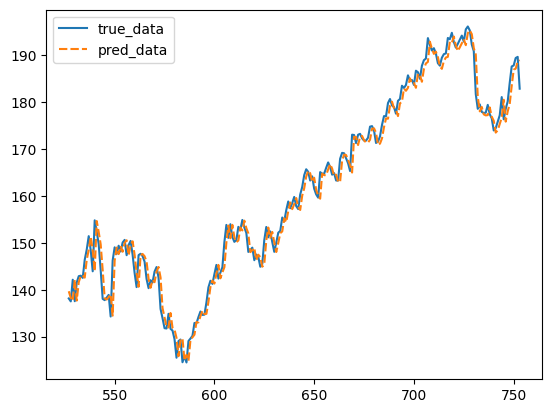

In [118]:
sns.lineplot(data=df_pred)

<Axes: xlabel='true_data', ylabel='pred_data'>

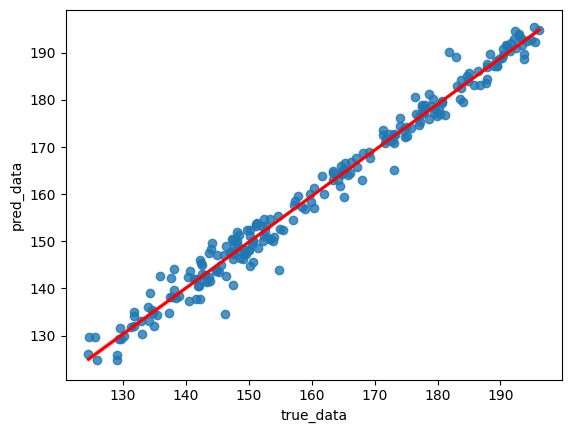

In [125]:
sns.regplot(x=df_pred['true_data'],y=df_pred['pred_data'],line_kws = {"color": "red"})

## Dynamic Testing

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Train your model as you have done
lr = LinearRegression()
lr.fit(x_train, y_train)

# Initialize an empty list to store predicted 'close' values
predicted_close_values = []

# Initialize an empty list to store 'trend_3_day' values
trend_3_day_values = []

# Iterate through the test dataset
for index, row in x_test.iterrows():
    # Make a prediction for the current data point
    # Provide both 'day_prev_close' and 'trend_3_day' as input features
    features_for_prediction = np.array([row['day_prev_close'], row['trend_3_day']]).reshape(1, -1)
    y_pred = lr.predict(features_for_prediction)

    # Append the predicted 'close' value to the list
    predicted_close_values.append(y_pred[0])

    # Calculate the 'trend_3_day' based on the predicted 'close' value
    trend_3_day = 1 if y_pred > row['day_prev_close'] else -1
    trend_3_day_values.append(trend_3_day)

    # Update the 'day_prev_close' value for the next iteration
    row['day_prev_close'] = y_pred[0]

# Assign the predicted values to the test dataset
x_test['day_prev_close'] = predicted_close_values
x_test['trend_3_day'] = trend_3_day_values

# Now, x_test contains the updated 'day_prev_close' and 'trend_3_day' features based on dynamic predictions

# Evaluate your model on the updated test dataset
def calculate_explained_variance(y_true, y_pred):
    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    return explained_variance

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2, mae, mse, rmse, explained_variance

# Evaluate your model on the updated test dataset
test_r2, test_mae, test_mse, test_rmse, test_explained_variance = evaluate_model(lr, x_test, y_test)

# Print the evaluation metrics
print("Test R^2 Score:", test_r2)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test Explained Variance:", test_explained_variance)


Test R^2 Score: 0.9822684144708003
Test MAE: 1.9536593698803477
Test MSE: 6.617166224331351
Test RMSE: 2.5723853180134872
Test Explained Variance: 0.9829602056882765


C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not ha

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    test_r2 = r2_score(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
    overfitting_indication = train_r2 - test_r2
    
    return model,test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication
# Define a dictionary of models
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

# Initialize empty lists to store performance metrics
model_names = []
test_r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []
variance_scores = []
overfitting_scores = []

# Loop through the models and evaluate each one
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(x_train, y_train)
    
    # Iterate through the test dataset for dynamic updates
    predicted_close_values = []
    trend_3_day_values = []

    for index, row in x_test.iterrows():
        # Make a prediction for the current data point
        features_for_prediction = np.array([row['day_prev_close'], row['trend_3_day']]).reshape(1, -1)
        y_pred = model.predict(features_for_prediction)

        # Append the predicted 'close' value to the list
        predicted_close_values.append(y_pred[0])

        # Calculate the 'trend_3_day' based on the predicted 'close' value
        trend_3_day = 1 if y_pred > row['day_prev_close'] else -1
        trend_3_day_values.append(trend_3_day)

        # Update the 'day_prev_close' value for the next iteration
        row['day_prev_close'] = y_pred[0]

    # Assign the predicted values to the test dataset
    x_test['day_prev_close'] = predicted_close_values
    x_test['trend_3_day'] = trend_3_day_values

    # Evaluate the model on the updated test dataset
    model,test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication = evaluate_model(model, x_train, y_train, x_test, y_test)
    
    # Append the results to the lists
    model_names.append(model_name)
    test_r2_scores.append(test_r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    variance_scores.append(explained_variance)
    overfitting_scores.append(overfitting_indication)

# Create a DataFrame to store the results
data = {
    'model': model_names,
    'score': test_r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'Variance Score': variance_scores,
    'Indication Overfitting': overfitting_scores
}

df_eval = pd.DataFrame(data)

# Sort the DataFrame by Variance Score in descending order
df_eval = df_eval.sort_values(by='Variance Score', ascending=False)

# Display the sorted DataFrame
print(df_eval)

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not ha

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: U

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: U

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: U

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: U

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does n

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does n

C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Hanif\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does n

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 2
[LightGBM] [Info] Start training from score 143.446858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\Hanif\AppData\Local\Temp\ipykernel_224252\224387345.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['day_prev_close'] = predicted_close_values
C:\Users\Hanif\AppData\Local\Temp\ipykernel_224252\224387345.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['trend_3_day'] = trend_3_day_values


In [31]:
df_eval 

,model,score,MAE,MSE,RMSE,Variance Score,Indication Overfitting
4,Random Forest,0.839876,5.939112,59.755896,7.730194,0.855381,0.155886
6,XGBoost,0.818437,6.357584,67.756677,8.231444,0.838147,0.178992
7,LightGBM,0.805809,6.491110,72.469047,8.512875,0.833841,0.175417
0,Linear,0.790220,6.680877,78.286972,8.847993,0.832686,0.185797
1,Lasso,0.775233,6.916580,83.879622,9.158582,0.824940,0.200741
2,Ridge,0.773948,6.934325,84.359312,9.184733,0.823995,0.202069
5,AdaBoost,0.765485,7.099995,87.517443,9.355076,0.813105,0.209808
3,Decision Tree,0.739976,7.490844,97.037086,9.850740,0.800760,0.259868
